In [96]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [97]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Create the base instance of the ChatOpenAI class
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [98]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )


class GenerateAnalystsState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # Analyst asking questions

In [99]:
analyst_instructions="""
You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
       
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.
""".strip()

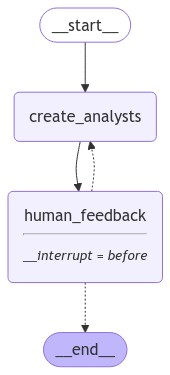

In [100]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def node_create_analysts(state: GenerateAnalystsState):
    """Create analysts"""

    # Topic to research
    topic = state['topic']
    # Maximum number of analysts
    max_analysts = state['max_analysts']
    # Human feedback
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    # Force the LLM to answer with the Perspectives structure which is a list
    # of Analysts
    structured_llm = llm.with_structured_output(Perspectives)

    # Create the prompt using the graph state
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    # Generate question
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] +
        [HumanMessage(content="Generate the set of analysts.")]
    )

    # GenerateAnalystsState has a list of Analysts, and Perspectives has a list of Analysts
    # so we forced the LLM to answer with the structure we wanted and store it result
    # in the state
    return {"analysts": analysts.analysts}


def node_human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass


def node_should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback', None)

    # If there is human feedback, we need to revisit the create_analysts node
    # because the logic uses the feedback to refine the list of Analysts
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END


# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)

builder.add_node("create_analysts", node_create_analysts)
builder.add_node("human_feedback", node_human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", node_should_continue)

# Compile
memory = MemorySaver()
graph = builder.compile(
    interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [101]:
import random
import string

thread_id = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

config = {
    "configurable": {
        "thread_id": thread_id
    }
}

initial_state = {
    "topic": "The impact of climate change on the economy",
    "max_analysts": 3,
    "human_analyst_feedback": "",
    "analysts": []
}

# Execute the graph till we reach the call to pass human feedback
for event in graph.stream(initial_state, config, stream_mode="values"):
    for analyst in event.get('analysts'):
        print(analyst.persona)

Name: Dr. Emily Carter
Role: Economic Impact Analyst
Affiliation: International Monetary Fund (IMF)
Description: Dr. Carter focuses on analyzing the macroeconomic effects of climate change, including GDP fluctuations, employment shifts, and fiscal policy adjustments. Her primary concern is understanding how climate change can alter economic stability and growth patterns globally. She aims to provide insights that can help policymakers mitigate negative economic impacts.

Name: Prof. Michael Green
Role: Environmental Policy Analyst
Affiliation: World Resources Institute
Description: Prof. Green examines the intersection of environmental policies and economic outcomes. He is particularly interested in how climate change policies can drive economic innovation and transformation. His motive is to identify policy frameworks that not only address environmental concerns but also promote sustainable economic development.

Name: Dr. Sarah Lin
Role: Social Impact Analyst
Affiliation: Oxford Univ

In [102]:
# Access the graph state and verify the next node to execute
snapshot = graph.get_state(config)
snapshot.next

('human_feedback',)

In [103]:
# Update the state (we are forcing to reloop the create_analysts node)
update_state = {
    "human_analyst_feedback": "add an advanced phisicist to the board",
}

# We now update the state as if we are the human_feedback node
graph.update_state(
    config,
    update_state,   
    as_node="human_feedback"
)

{'configurable': {'thread_id': 'KeWfnQ',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8fe51-239e-6d9c-8002-5fe749cb96a0'}}

In [104]:
last_analysts = False

# Continue the graph execution with updates mode
for event in graph.stream(None, config, stream_mode="values"):
    # Update the last_analysts with the current event's analysts
    last_analysts = event.get('analysts')

# After the loop, print the last analysts value
if last_analysts:
    for analyst in last_analysts:
        print(analyst.persona)

Name: Dr. Emily Carter
Role: Environmental Economist
Affiliation: Global Economic Forum
Description: Dr. Carter focuses on the economic implications of climate change, analyzing how shifts in climate patterns affect global markets, trade, and economic stability. She is concerned with developing sustainable economic policies that mitigate climate risks and promote green growth.

Name: Prof. Michael Green
Role: Climate Policy Analyst
Affiliation: International Climate Policy Institute
Description: Prof. Green examines the intersection of climate change and policy-making, evaluating the effectiveness of international agreements and national policies in addressing climate change. His work is driven by the need to create robust policy frameworks that support economic resilience in the face of climate change.

Name: Dr. Sarah Thompson
Role: Advanced Physicist
Affiliation: Institute of Advanced Physics
Description: Dr. Thompson investigates the physical processes driving climate change and th

In [106]:
# Update the state (we are forcing to reloop the create_analysts node)
update_state = {
    "human_analyst_feedback": None
}

# We now update the state as if we are the human_feedback node
graph.update_state(
    config,
    update_state,   
    as_node="human_feedback"
)

# Continue the graph execution to end
for event in graph.stream(None, config, stream_mode="values"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

snapshot = graph.get_state(config)
snapshot.next

--Node--
topic


()